<a href="https://colab.research.google.com/github/Olayasser301/Mental-health-pred/blob/main/Mental_health_pred_in_tech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Data import
survey_2016 = pd.read_csv("mental-heath-in-tech-2016_20161114.csv")

In [105]:
# ----------- CLEANING THE DATA -----------
# Column rename
renamed_columns = ['self_empl_flag', 'comp_no_empl', 'tech_comp_flag', 'tech_role_flag', 'mh_coverage_flag',
                  'mh_coverage_awareness_flag', 'mh_employer_discussion', 'mh_resources_provided', 'mh_anonimity_flag',
                  'mh_medical_leave', 'mh_discussion_neg_impact', 'ph_discussion_neg_impact', 'mh_discussion_cowork',
                  'mh_discussion_supervis', 'mh_eq_ph_employer', 'mh_conseq_coworkers', 'mh_coverage_flag2', 'mh_online_res_flag',
                  'mh_diagnosed&reveal_clients_flag', 'mh_diagnosed&reveal_clients_impact', 'mh_diagnosed&reveal_cowork_flag', 'mh_cowork_reveal_neg_impact',
                  'mh_prod_impact', 'mh_prod_impact_perc', 'prev_employers_flag', 'prev_mh_benefits', 'prev_mh_benefits_awareness',
                  'prev_mh_discussion', 'prev_mh_resources', 'prev_mh_anonimity', 'prev_mh_discuss_neg_conseq', 'prev_ph_discuss_neg_conseq',
                  'prev_mh_discussion_cowork', 'prev_mh_discussion_supervisor', 'prev_mh_importance_employer', 'prev_mh_conseq_coworkers',
                  'future_ph_specification', 'why/why_not', 'future_mh_specification', 'why/why_not2', 'mh_hurt_on_career', 'mh_neg_view_cowork',
                  'mh_sharing_friends/fam_flag', 'mh_bad_response_workplace', 'mh_for_others_bad_response_workplace', 'mh_family_hist',
                  'mh_disorder_past', 'mh_disorder_current', 'yes:what_diagnosis?', 'maybe:whats_your_diag', 'mh_diagnos_proffesional',
                  'yes:condition_diagnosed', 'mh_sought_proffes_treatm', 'mh_eff_treat_impact_on_work', 'mh_not_eff_treat_impact_on_work',
                  'age', 'sex', 'country_live', 'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position', 'remote_flag']
survey_2016.columns = renamed_columns

In [106]:
# Sex column needs to be recoded (number of unique values = 70)
survey_2016['sex'].replace(to_replace = ['Male', 'male', 'Male ', 'M', 'm',
       'man', 'Cis male', 'Male.', 'male 9:1 female, roughly', 'Male (cis)', 'Man', 'Sex is male',
       'cis male', 'Malr', 'Dude', "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
       'mail', 'M|', 'Male/genderqueer', 'male ',
       'Cis Male', 'Male (trans, FtM)',
       'cisdude', 'cis man', 'MALE'], value = 1, inplace = True)

survey_2016['sex'].replace(to_replace = ['Female', 'female', 'I identify as female.', 'female ',
       'Female assigned at birth ', 'F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F',
       'Genderfluid (born female)', 'Female or Multi-Gender Femme', 'Female ', 'woman', 'female/woman',
       'Cisgender Female', 'fem', 'Female (props for making this a freeform field, though)',
       ' Female', 'Cis-woman', 'female-bodied; no feelings about gender',
       'AFAB'], value = 2, inplace = True)

survey_2016['sex'].replace(to_replace = ['Bigender', 'non-binary', 'Other/Transfeminine',
       'Androgynous', 'Other', 'nb masculine',
       'none of your business', 'genderqueer', 'Human', 'Genderfluid',
       'Enby', 'genderqueer woman', 'mtf', 'Queer', 'Agender', 'Fluid',
       'Nonbinary', 'human', 'Unicorn', 'Genderqueer',
       'Genderflux demi-girl', 'Transgender woman'], value = 3, inplace = True)
survey_2016['sex'].value_counts()

sex
1.0    1060
2.0     343
3.0      27
Name: count, dtype: int64

In [107]:
# Recode Comp size & country columns (for ease when doing plots)
survey_2016['comp_no_empl'].replace(to_replace = ['More than 1000'], value = '>1000', inplace = True)
survey_2016['country_live'].replace(to_replace = ['United States of America'], value = 'USA', inplace = True)
survey_2016['country_live'].replace(to_replace = ['United Kingdom'], value = 'UK', inplace = True)
survey_2016['country_work'].replace(to_replace = ['United States of America'], value = 'USA', inplace = True)
survey_2016['country_work'].replace(to_replace = ['United Kingdom'], value = 'UK', inplace = True)

# Max age is 323, min age is 3.
# There are only 5 people that have weird ages (3yo, 15yo, or 99yo or 323 yo.)
# These people will take the average age of the dataset (the correct calculated one, w/out outliers)
mean_age = survey_2016[(survey_2016['age'] >= 18) | (survey_2016['age'] <= 75)]['age'].mean()
survey_2016['age'].replace(to_replace = survey_2016[(survey_2016['age'] < 18) | (survey_2016['age'] > 75)]['age'].tolist(),
                          value = mean_age, inplace = True)

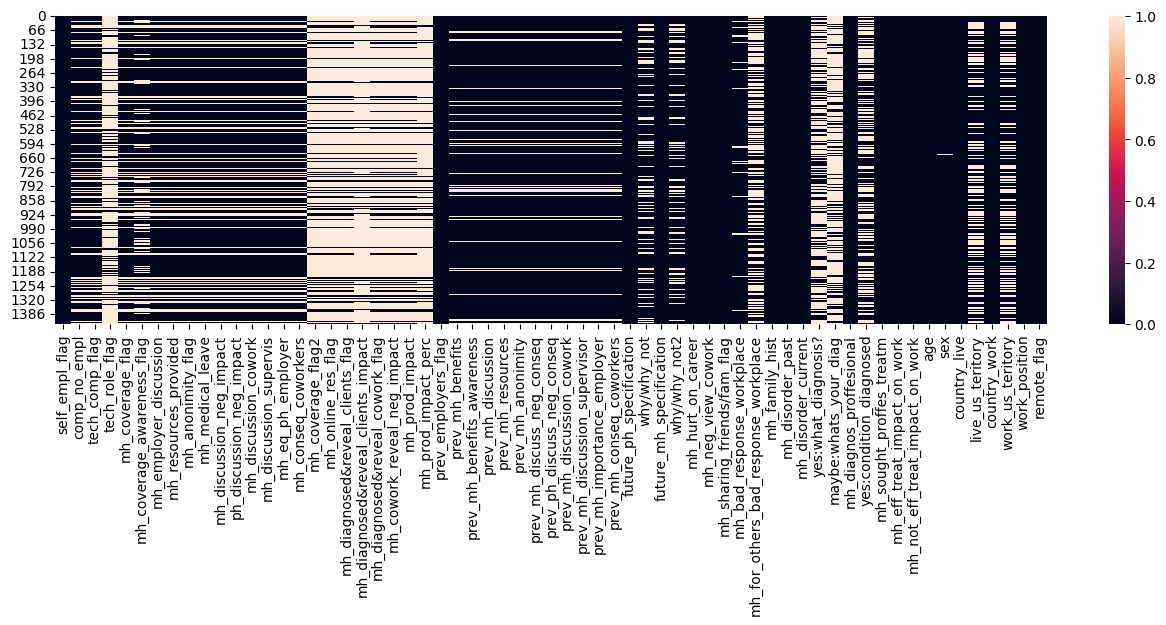

In [108]:
# ----------- MISSING VALUES -----------
# Missing values visualisation
plt.figure(figsize = (16,4))
sns.heatmap(data = survey_2016.isna());

In [109]:
# The survey has 1433 rows, so first we will drop all columns where more than half of the observations have missing values
cols = (survey_2016.isna().sum() >= survey_2016.shape[0]/2).tolist()
to_drop = survey_2016.columns[cols]
survey_2016.drop(labels = to_drop, axis = 1, inplace = True)

# Dealing with other missing values
from sklearn.impute import SimpleImputer

# Impute nan with the most frequent value (mode) on every row
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(survey_2016)
imp_data = pd.DataFrame(data = imp.transform(survey_2016), columns = survey_2016.columns)

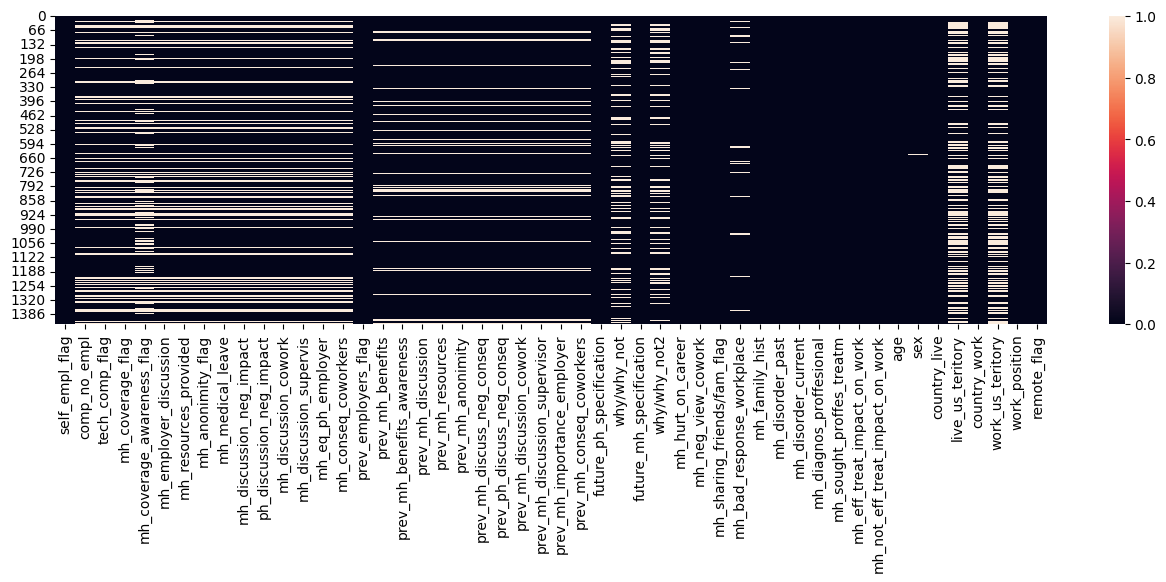

In [110]:
# ----------- MISSING VALUES -----------
# Missing values visualisation after removing the undesired columns where more than half are nan values.
plt.figure(figsize = (16,4))
sns.heatmap(data = survey_2016.isna());

In [111]:
survey_2016

,self_empl_flag,comp_no_empl,tech_comp_flag,mh_coverage_flag,mh_coverage_awareness_flag,mh_employer_discussion,mh_resources_provided,mh_anonimity_flag,mh_medical_leave,mh_discussion_neg_impact,...,mh_eff_treat_impact_on_work,mh_not_eff_treat_impact_on_work,age,sex,country_live,live_us_teritory,country_work,work_us_teritory,work_position,remote_flag
0,0,26-100,1.0,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,No,...,Not applicable to me,Not applicable to me,39.0,1.0,UK,NaN,UK,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,No,Yes,Yes,Yes,Yes,Somewhat easy,No,...,Rarely,Sometimes,29.0,1.0,USA,Illinois,USA,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,No,NaN,No,No,I don't know,Neither easy nor difficult,Maybe,...,Not applicable to me,Not applicable to me,38.0,1.0,UK,NaN,UK,NaN,Back-end Developer,Always
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sometimes,Sometimes,43.0,1.0,UK,NaN,UK,NaN,Supervisor/Team Lead,Sometimes
4,0,6-25,0.0,Yes,Yes,No,No,No,Neither easy nor difficult,Yes,...,Sometimes,Sometimes,43.0,2.0,USA,Illinois,USA,Illinois,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Not applicable to me,Not applicable to me,34.0,2.0,USA,New York,USA,New York,Other,Sometimes
1429,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sometimes,Often,56.0,1.0,USA,California,Afghanistan,NaN,Support,Sometimes
1430,0,100-500,1.0,Yes,Yes,Yes,Yes,I don't know,Somewhat difficult,Maybe,...,Rarely,Sometimes,52.0,1.0,USA,Georgia,USA,Georgia,Back-end Developer,Sometimes
1431,0,100-500,0.0,I don't know,I am not sure,No,Yes,I don't know,Somewhat difficult,Maybe,...,Sometimes,Often,30.0,2.0,USA,Nebraska,USA,Nebraska,DevOps/SysAdmin,Sometimes


In [112]:
def one_hot_encode(original_column, column_names, values, mappings):
    for column, value, mapping in zip(column_names, values, mappings):
        survey_2016[column]

In [113]:
# ----------- ENCODING -----------
# Split data into 2 datasets: one that needs to be encoded, one that doesnt need to
cols = [x for x in imp_data.columns if x not in ['age', 'why/why_not', 'why/why_not2', 'country_live',
       'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position']]

data_to_encode = imp_data[cols]
data_not_encode = imp_data[['why/why_not', 'why/why_not2', 'country_live',
       'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position']]

In [114]:
data_to_encode

,self_empl_flag,comp_no_empl,tech_comp_flag,mh_coverage_flag,mh_coverage_awareness_flag,mh_employer_discussion,mh_resources_provided,mh_anonimity_flag,mh_medical_leave,mh_discussion_neg_impact,...,mh_bad_response_workplace,mh_family_hist,mh_disorder_past,mh_disorder_current,mh_diagnos_proffesional,mh_sought_proffes_treatm,mh_eff_treat_impact_on_work,mh_not_eff_treat_impact_on_work,sex,remote_flag
0,0,26-100,1.0,Not eligible for coverage / N/A,No,No,No,I don't know,Very easy,No,...,No,No,Yes,No,Yes,0,Not applicable to me,Not applicable to me,1.0,Sometimes
1,0,6-25,1.0,No,Yes,Yes,Yes,Yes,Somewhat easy,No,...,No,Yes,Yes,Yes,Yes,1,Rarely,Sometimes,1.0,Never
2,0,6-25,1.0,No,No,No,No,I don't know,Neither easy nor difficult,Maybe,...,Maybe/Not sure,No,Maybe,No,No,1,Not applicable to me,Not applicable to me,1.0,Always
3,1,26-100,1.0,Yes,No,No,No,I don't know,Somewhat easy,Maybe,...,No,No,Yes,Yes,Yes,1,Sometimes,Sometimes,1.0,Sometimes
4,0,6-25,0.0,Yes,Yes,No,No,No,Neither easy nor difficult,Yes,...,"Yes, I experienced",Yes,Yes,Yes,Yes,1,Sometimes,Sometimes,2.0,Sometimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,1,26-100,1.0,Yes,No,No,No,I don't know,Somewhat easy,Maybe,...,Maybe/Not sure,Yes,No,No,No,1,Not applicable to me,Not applicable to me,2.0,Sometimes
1429,1,26-100,1.0,Yes,No,No,No,I don't know,Somewhat easy,Maybe,...,Maybe/Not sure,Yes,No,No,Yes,0,Sometimes,Often,1.0,Sometimes
1430,0,100-500,1.0,Yes,Yes,Yes,Yes,I don't know,Somewhat difficult,Maybe,...,"Yes, I observed",Yes,Yes,Maybe,Yes,1,Rarely,Sometimes,1.0,Sometimes
1431,0,100-500,0.0,I don't know,I am not sure,No,Yes,I don't know,Somewhat difficult,Maybe,...,"Yes, I experienced",Yes,Maybe,Yes,Yes,0,Sometimes,Often,2.0,Sometimes


In [115]:
data_to_encode_random = data_to_encode.sample(frac = 1)

In [116]:
data_to_encode.shape

(1433, 42)

In [117]:
take = 1000
data_to_encode_training = data_to_encode_random[:take]
data_to_encode_testing = data_to_encode_random[take:]

In [118]:
data_to_encode_training.shape, data_to_encode_testing.shape

((1000, 42), (433, 42))

In [328]:
feature_columns = ["self_empl_flag", "comp_no_empl", "sex", "tech_comp_flag", "mh_family_hist", "mh_disorder_past" , "mh_diagnos_proffesional" ]
# label_columns = ["mh_diagnos_proffesional"]
label_columns = ["mh_disorder_current"]

In [329]:
X_train_frame = data_to_encode_training[feature_columns]
X_test_frame = data_to_encode_testing[feature_columns]

In [330]:
Y_train_frame = data_to_encode_training[label_columns]
Y_test_frame = data_to_encode_testing[label_columns]

In [331]:
data_to_encode.mh_disorder_current.value_counts()

mh_disorder_current
Yes      575
No       531
Maybe    327
Name: count, dtype: int64

In [332]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [334]:
features = OneHotEncoder()
labels = LabelEncoder()

In [333]:
features = features.fit(X_train_frame)
X_train = features.transform(X_train_frame)
X_test = features.transform(X_test_frame)

In [335]:
labels = labels.fit(Y_train_frame)
Y_train = labels.transform(Y_train_frame)
Y_test = labels.transform(Y_test_frame)

Text(0.5, 1.0, 'Distribution of "comp_no_empl" Column')

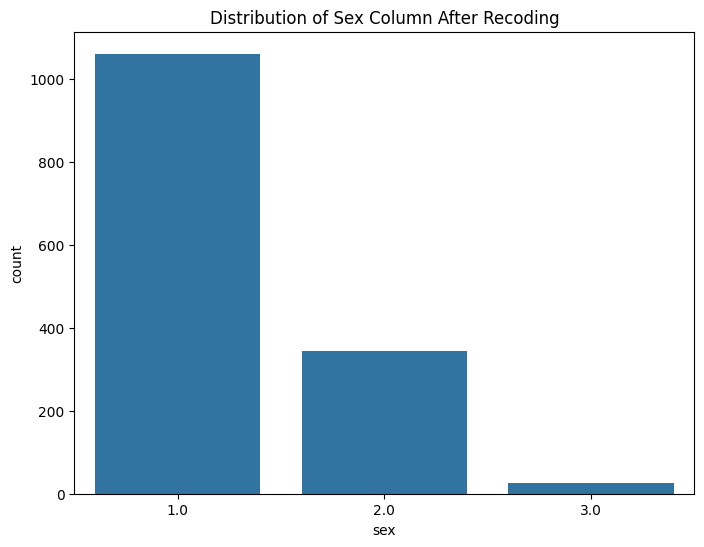

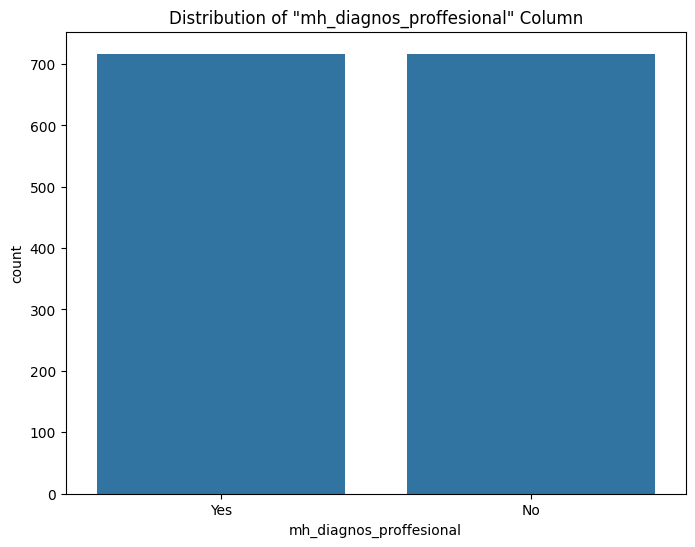

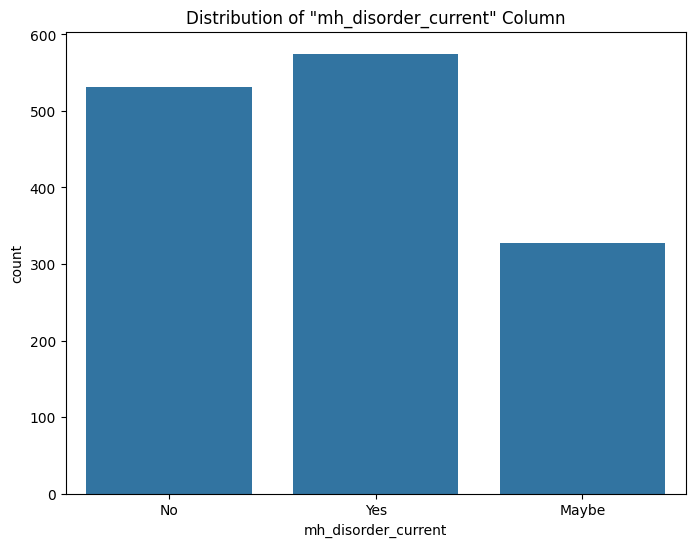

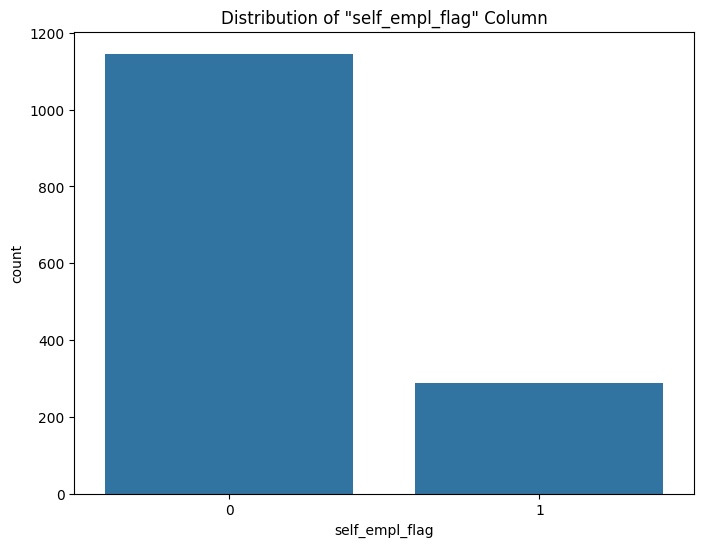

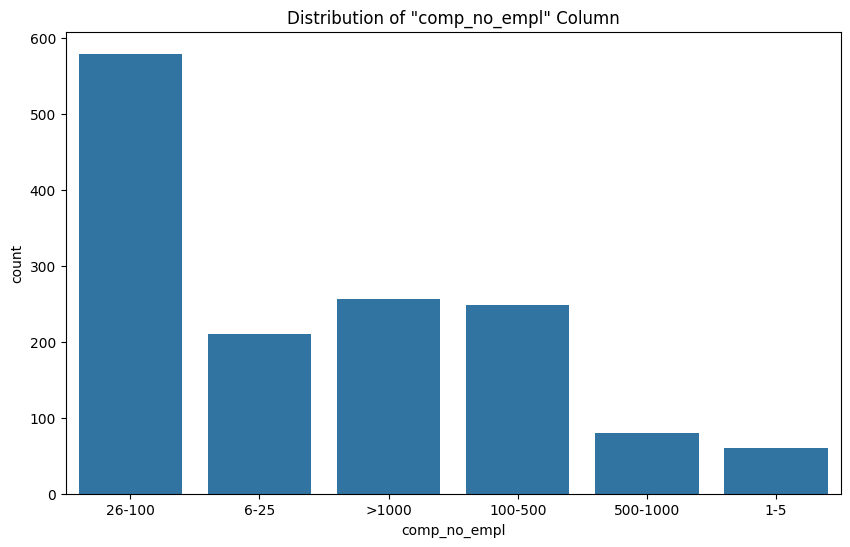

In [295]:
# Distribution of Sex Column After Recoding
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=survey_2016)
plt.title('Distribution of Sex Column After Recoding')

# Distribution of 'mh_diagnos_proffesional' Column
plt.figure(figsize=(8, 6))
sns.countplot(x='mh_diagnos_proffesional', data=data_to_encode)
plt.title('Distribution of "mh_diagnos_proffesional" Column')

# Distribution of 'mh_disorder_current' Column
plt.figure(figsize=(8, 6))
sns.countplot(x='mh_disorder_current', data=data_to_encode)
plt.title('Distribution of "mh_disorder_current" Column')

# Distribution of 'self_empl_flag' Column
plt.figure(figsize=(8, 6))
sns.countplot(x='self_empl_flag', data=data_to_encode)
plt.title('Distribution of "self_empl_flag" Column')

# Distribution of 'comp_no_empl' Column
plt.figure(figsize=(10, 6))
sns.countplot(x='comp_no_empl', data=data_to_encode)
plt.title('Distribution of "comp_no_empl" Column')


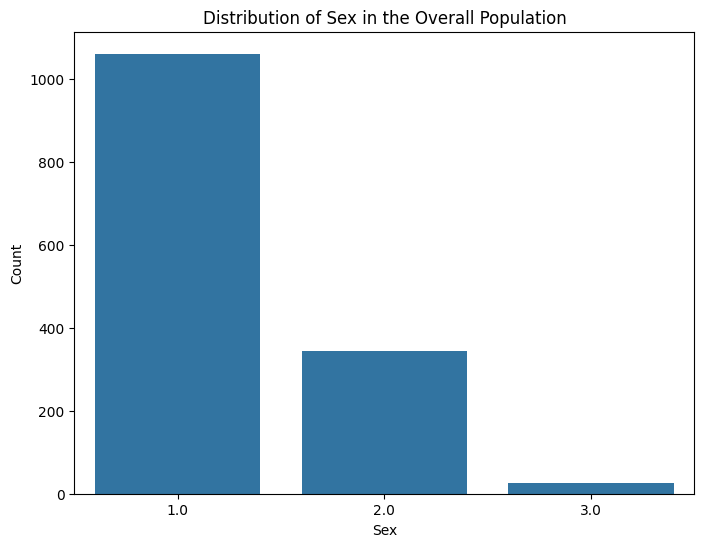

In [296]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=survey_2016)
plt.title('Distribution of Sex in the Overall Population')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


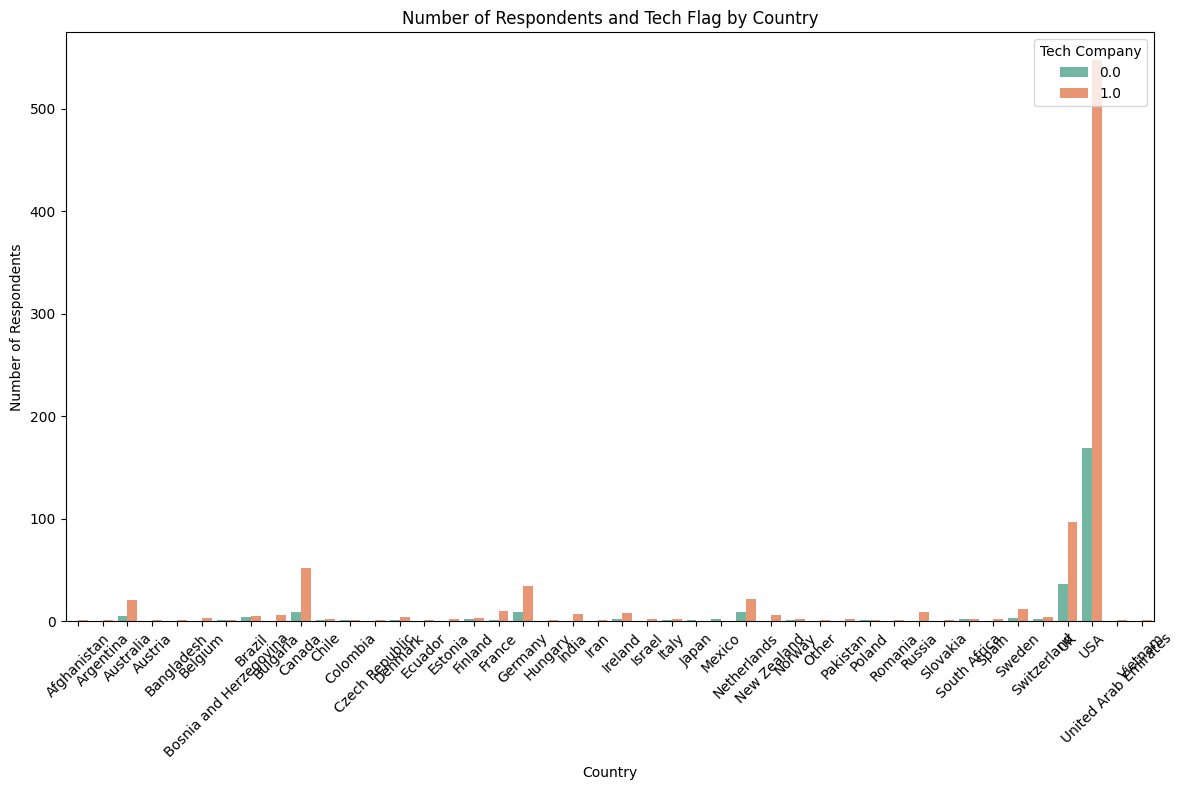

In [297]:
# Create a DataFrame containing the count of respondents per country and tech flag
country_tech_counts = survey_2016.groupby(['country_work', 'tech_comp_flag']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(12, 8))

# Bar plot for number of respondents per country
sns.barplot(x='country_work', y='count', data=country_tech_counts, hue='tech_comp_flag', palette='Set2')
plt.title('Number of Respondents and Tech Flag by Country')
plt.xlabel('Country')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45)
plt.legend(title='Tech Company', loc='upper right')
plt.tight_layout()
plt.show()


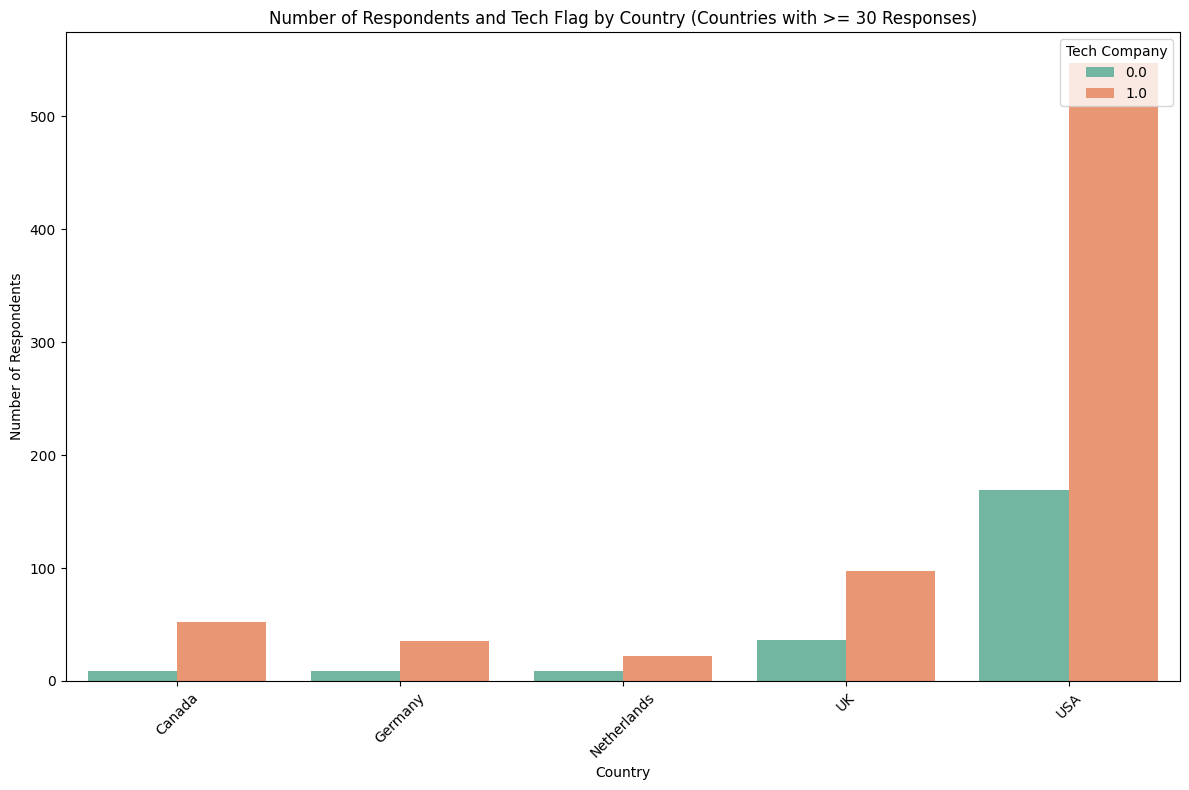

In [298]:
# Filter out countries with less than 30 responses
filtered_country_tech_counts = country_tech_counts.groupby('country_work').filter(lambda x: x['count'].sum() >= 30)

# Plotting
plt.figure(figsize=(12, 8))

# Bar plot for number of respondents per country
sns.barplot(x='country_work', y='count', data=filtered_country_tech_counts, hue='tech_comp_flag', palette='Set2')
plt.title('Number of Respondents and Tech Flag by Country (Countries with >= 30 Responses)')
plt.xlabel('Country')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45)
plt.legend(title='Tech Company', loc='upper right')
plt.tight_layout()
plt.show()

# 1 =  in tech while 0= not in tech

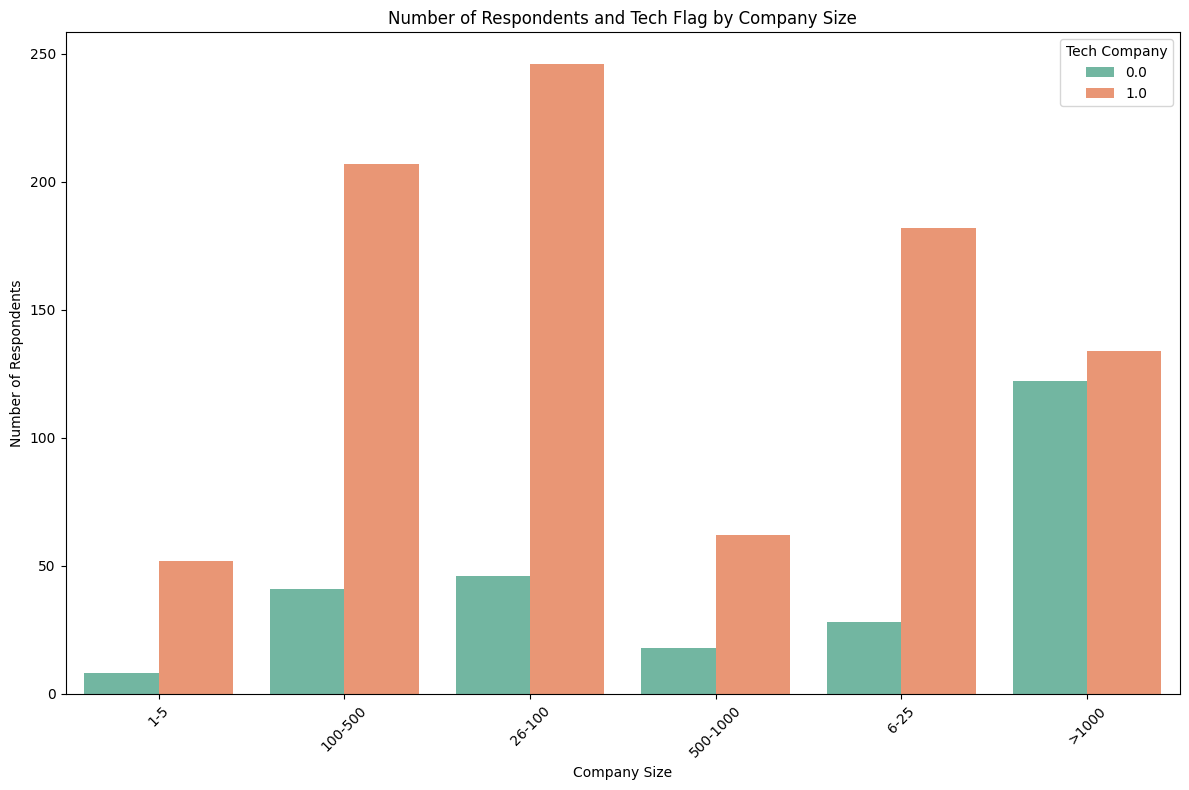

In [299]:
# Create a DataFrame containing the count of respondents per company size and tech flag
company_size_tech_counts = survey_2016.groupby(['comp_no_empl', 'tech_comp_flag']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(12, 8))

# Bar plot for number of respondents per company size
sns.barplot(x='comp_no_empl', y='count', data=company_size_tech_counts, hue='tech_comp_flag', palette='Set2')
plt.title('Number of Respondents and Tech Flag by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Number of Respondents')
plt.xticks(rotation=45)
plt.legend(title='Tech Company', loc='upper right')
plt.tight_layout()
plt.show()


In [336]:
from sklearn import linear_model

In [385]:
from sklearn.svm import SVC

In [384]:
from sklearn.neural_network import MLPClassifier
#clf = MLPClassifier(solver='adam', hidden_layer_sizes=(28,10, 2 ), random_state=1)

In [386]:
import xgboost as xgb
#clf = xgb.XGBRFClassifier()


In [387]:
 #clf = linear_model.Perceptron()
clf = SVC()

In [388]:
model = clf.fit(X_train, Y_train)

In [389]:
model.score(X_test, Y_test)

0.745958429561201

In [390]:
Y_test_pred = model.predict(X_test)

In [391]:
Y_test_frame["truth"] = Y_test_frame[label_columns]

In [392]:
Y_test_frame["prediction"] = labels.inverse_transform(Y_test_pred)

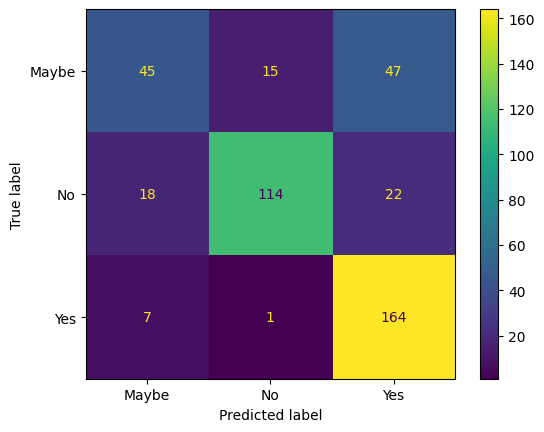

In [393]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(Y_test_frame.truth, Y_test_frame.prediction, labels=labels.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.classes_)
disp.plot()

In [394]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test_frame.truth, Y_test_frame.prediction)

0.745958429561201